## Project idea 4:
### implement and test at least 6 different variants of Isomap for DGP: the three above, and at least three new ones of your own conception

In [1]:

# The only 3 lines you need to install and use AMPL with any solver on Colab
%pip install -q amplpy
from amplpy import AMPL, ampl_notebook

P = ampl_notebook(
    modules=["highs", "gurobi"],  # modules to install (guroby is the best solver)
    license_uuid="bf5b5ed2-ea35-4373-8776-1ab021939a37",  # license to use
)  # instantiate AMPL object and register magics

Note: you may need to restart the kernel to use updated packages.
Licensed to Bundle #6415.6806 expiring 20240515: INF580 Large-scale optimization, Leo Liberti, LIX Ecole Polytechnique.


### Isomap for DGP


[(0, 2, {'weight': 5}), (0, 3, {'weight': 2}), (0, 7, {'weight': 2}), (0, 9, {'weight': 4}), (0, 15, {'weight': 1}), (0, 16, {'weight': 10}), (0, 17, {'weight': 5}), (0, 19, {'weight': 5}), (0, 24, {'weight': 9}), (0, 26, {'weight': 6}), (0, 27, {'weight': 9}), (0, 31, {'weight': 5}), (0, 32, {'weight': 8}), (0, 34, {'weight': 3}), (0, 35, {'weight': 4}), (0, 36, {'weight': 8}), (0, 37, {'weight': 6}), (0, 38, {'weight': 7}), (0, 41, {'weight': 7}), (0, 48, {'weight': 2}), (1, 2, {'weight': 7}), (1, 6, {'weight': 7}), (1, 7, {'weight': 8}), (1, 8, {'weight': 7}), (1, 10, {'weight': 5}), (1, 11, {'weight': 9}), (1, 13, {'weight': 3}), (1, 15, {'weight': 2}), (1, 17, {'weight': 9}), (1, 23, {'weight': 1}), (1, 24, {'weight': 5}), (1, 26, {'weight': 6}), (1, 27, {'weight': 9}), (1, 28, {'weight': 4}), (1, 31, {'weight': 2}), (1, 32, {'weight': 4}), (1, 35, {'weight': 7}), (1, 39, {'weight': 5}), (1, 40, {'weight': 6}), (1, 41, {'weight': 4}), (1, 43, {'weight': 5}), (1, 44, {'weight': 9})

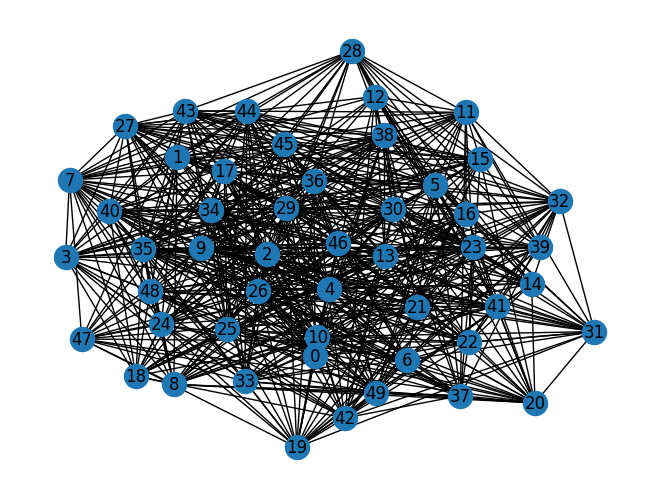

In [13]:
import networkx as nx
import random
import matplotlib.pyplot as plt

def biconnected_graph(n):
   G = nx.gnp_random_graph(n, 0.5, directed=False)
   while(not nx.is_biconnected(G)):
         G = nx.gnp_random_graph(n, 0.5, directed=False)
   for (u, v) in G.edges():
       G[u][v]['weight'] = random.randint(1, 10)
   return G

G = biconnected_graph(10)
print(G.edges(data=True))
nx.draw(G, with_labels=True)

In [5]:

with open('biconnected_graph.dat', 'w') as f:
    f.write("# file generated by clique-instgen.run")
    f.write("\n")
    f.write("param n := %d;\n" % 50)
    f.write("set E :=")
    for (i,j) in G.edges():
        weight=G[i][j]['weight']
        f.write(" (%d,%d)" % (i,j))
    f.write(";\n")
    f.close()


In [6]:
def floyd_warshall(G):
    for i in G.nodes():
        for j in G.nodes():
            if i != j and not G.has_edge(i, j):
                found=False
                for k in G.nodes():
                    if i != k and j != k and G.has_edge(i, k) and G.has_edge(k, j):
                        found=True
                        break
                if not found:
                    return False
    return True
            
print(floyd_warshall(G))

True
